In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("/workspace/circuit-finder")

In [3]:
dataset_name = 'gender-bias'
metric_fn_name = "logit_diff"

In [4]:
import pickle
from circuit_finder.constants import ProjectDir
from circuit_finder.experiments.run_leap_experiment import LeapExperimentResult

with open(ProjectDir / 'leap_experiment_results' / f'dataset={dataset_name}_threshold=0.01' / 'result.pkl', 'rb') as file:
    result = pickle.load(file)

print(result)

In [ ]:
from circuit_finder.pretrained import load_model
from circuit_finder.pretrained import load_attn_saes, load_hooked_mlp_transcoders
from circuit_finder.patching.indirect_leap import preprocess_attn_saes

model = load_model()
attn_sae_dict = load_attn_saes()
# TODO: get rid of need to preprocess attn saes
attn_sae_dict = preprocess_attn_saes(attn_sae_dict, model)
hooked_mlp_transcoder_dict = load_hooked_mlp_transcoders()

attn_saes = list(attn_sae_dict.values())
transcoders = list(hooked_mlp_transcoder_dict.values())

/workspace/circuit-finder/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

In [ ]:
from circuit_finder.experiments.run_leap_experiment import datasets, compute_logit_diff

dataset = datasets[dataset_name]

# Setup the tokens
clean_tokens = dataset.clean_tokens(model)
answer_tokens = dataset.answer_tokens(model)
wrong_answer_tokens = dataset.wrong_answer_tokens(model)
corrupt_tokens = dataset.corrupt_tokens(model)

# Setup the metric function
if metric_fn_name == "logit_diff":

    def metric_fn(model, tokens):
        logit_diff = compute_logit_diff(
            model, tokens, answer_tokens, wrong_answer_tokens
        )
        return logit_diff.mean()
else:
    raise ValueError(f"Unknown metric_fn_name: {metric_fn_name}")

In [ ]:
graph = result.graph

In [ ]:
all_nodes = graph.get_src_nodes()
all_nodes = [n for n in all_nodes if "metric" not in n]
print(len(all_nodes))

318


# Causal Ablations

In [ ]:
# Get the clean and corrupt cache
from circuit_finder.patching.ablate import (
    splice_model_with_saes_and_transcoders,
    filter_sae_acts_and_errors,
    get_ablation_result,
)

with splice_model_with_saes_and_transcoders(
    model, transcoders, attn_saes
) as spliced_model:
    _, clean_cache = model.run_with_cache(
        clean_tokens, names_filter=filter_sae_acts_and_errors
    )
    _, corrupt_cache = model.run_with_cache(
        corrupt_tokens, names_filter=filter_sae_acts_and_errors
    )

noising_result = get_ablation_result(
    model,
    transcoders,
    attn_saes,
    clean_tokens = clean_tokens,
    corrupt_tokens = corrupt_tokens,
    clean_cache = clean_cache,
    corrupt_cache = corrupt_cache,
    nodes = all_nodes,
    metric_fn = metric_fn,
    setting="noising",
)

denoising_result = get_ablation_result(
    model,
    transcoders,
    attn_saes,
    clean_tokens = clean_tokens,
    corrupt_tokens = corrupt_tokens,
    clean_cache = clean_cache,
    corrupt_cache = corrupt_cache,
    nodes = all_nodes,
    metric_fn = metric_fn,
    setting="denoising",
)

In [ ]:
print(noising_result)
print(denoising_result)

AblationResult(coefficient=[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0], metric=[0.12833690643310547, 0.2418346405029297, 0.3353729248046875, 0.4143943786621094, 0.4843025207519531, 0.5450305938720703, 0.5967884063720703, 0.6416769027709961, 0.681035041809082, 0.7168941497802734, 0.7484140396118164])
AblationResult(coefficient=[1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.3999999999999999, 0.29999999999999993, 0.19999999999999996, 0.09999999999999998, 0.0], metric=[-1.114640235900879, -1.2788000106811523, -1.451430320739746, -1.6302471160888672, -1.8153667449951172, -2.0058250427246094, -2.196417808532715, -2.385934829711914, -2.609673500061035, -2.832784652709961, -3.0455312728881836])


In [ ]:
clean_metric = result.clean_metric
corrupt_metric = result.corrupt_metric

results = {
    "noising": noising_result,
    "denoising": denoising_result,
}

Text(0, 0.5, 'Metric')

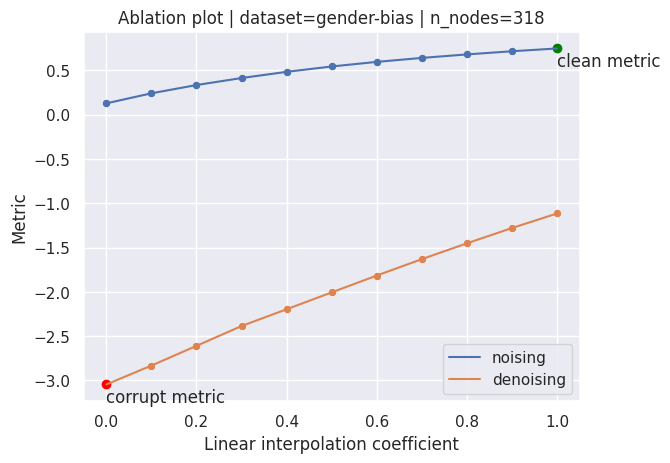

In [ ]:
# Plot the results

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
for setting, res in results.items():
    coefficients = res.coefficient
    metrics = res.metric
    sns.lineplot(x=coefficients, y=metrics, label=setting)
    sns.scatterplot(x=coefficients, y=metrics)
plt.legend()
# Add text
text_offset = -0.2
plt.scatter([1], [clean_metric], color="green")
plt.text(1, clean_metric + text_offset, "clean metric", fontsize=12)
plt.scatter([0], [corrupt_metric], color="red")
plt.text(0, corrupt_metric + text_offset, "corrupt metric", fontsize=12)

plt.title(f"Ablation plot | dataset={dataset_name} | n_nodes={len(all_nodes)}")
plt.xlabel("Linear interpolation coefficient")
plt.ylabel("Metric")